**Multi Horizon IMU Prediction**


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import numpy as np
import pandas as pd


# 1) Load data
def load_imu_csv(csv_file_path, tags=('acc', 'gyro')):
    df = pd.read_csv(csv_file_path, low_memory=False)
    df = df[df['tag'].isin(tags)].copy()
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    for c in ('x', 'y', 'z'):
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df.dropna(subset=['timestamp', 'x', 'y', 'z'], inplace=True)
    return df


# 2) Read F3 (cell row 3, col F) calibration JSON
def read_calibration_from_f3(csv_file_path):
    head = pd.read_csv(csv_file_path, header=None, nrows=3, dtype=str, engine="python")
    f3_raw = head.iat[2, 5]  # F3
    try:
        calib = json.loads(f3_raw)
    except json.JSONDecodeError as e:
        raise ValueError(f"Failed to parse JSON from cell F3: {e}\nValue in F3 was:\n{f3_raw}")

    # Defaults + reshaping
    b_gyro = np.array(calib.get('b_gyro1', [0, 0, 0]), dtype=float)
    Sgyro  = np.array(calib.get('Sgyro1',  [1,0,0,0,1,0,0,0,1]), dtype=float).reshape(3,3)

    b_acc = np.array(calib.get('b_acc1', [0, 0, 0]), dtype=float)
    Sacc  = np.array(calib.get('Sacc1',  [1,0,0,0,1,0,0,0,1]), dtype=float).reshape(3,3)

    return {
        'b_gyro': b_gyro, 'Sgyro': Sgyro,
        'b_acc': b_acc,   'Sacc': Sacc,
        'have_acc_cal': ('b_acc1' in calib) and ('Sacc1' in calib)
    }


# 3) Calibrate per tag
def apply_calibration(df: pd.DataFrame, cal: dict) -> pd.DataFrame:
    df = df.copy().reset_index(drop=True)  # ensure positional indexing
    # ensure float dtype for x,y,z
    df[['x','y','z']] = df[['x','y','z']].apply(pd.to_numeric, errors='coerce').astype('float64')

    # columns positions for iloc
    xyz_cols = [df.columns.get_loc(c) for c in ('x','y','z')]

    # calibration arrays
    b_gyro = np.asarray(cal['b_gyro'], dtype=float).reshape(3)
    Sgyro  = np.asarray(cal['Sgyro'],  dtype=float).reshape(3,3)

    have_acc = cal.get('have_acc_cal', ('b_acc' in cal and 'Sacc' in cal))
    if have_acc:
        b_acc = np.asarray(cal['b_acc'], dtype=float).reshape(3)
        Sacc  = np.asarray(cal['Sacc'],  dtype=float).reshape(3,3)

    # indices by tag (positional)
    tags = df['tag'].to_numpy()
    gyro_idx = np.flatnonzero(tags == 'gyro')
    acc_idx  = np.flatnonzero(tags == 'acc')

    # gyro calibration
    if gyro_idx.size:
        gvals = df.iloc[gyro_idx, xyz_cols].to_numpy(dtype=float)
        gcal  = (gvals - b_gyro) @ Sgyro.T
        df.iloc[gyro_idx, xyz_cols] = gcal

    # acc calibration
    if have_acc and acc_idx.size:
        avals = df.iloc[acc_idx, xyz_cols].to_numpy(dtype=float)
        acal  = (avals - b_acc) @ Sacc.T
        df.iloc[acc_idx, xyz_cols] = acal

    return df


# 4) Split each tag by a timestamp gap
def split_by_gap_timestamp(df: pd.DataFrame, gap_us=35_000, min_len=1):
    """
    Split by gaps in numeric 'timestamp' (µs). Returns list of DataFrames.
    """
    ts = pd.to_numeric(df['timestamp'], errors='coerce')
    order = np.argsort(ts.values)
    df = df.iloc[order].reset_index(drop=True)
    ts = ts.iloc[order].reset_index(drop=True)

    gaps = ts.diff().to_numpy()
    cuts = np.ones(len(df), dtype=bool)
    cuts[1:] = (gaps[1:] > gap_us)

    segs, start = [], 0
    for i in range(len(df)):
        if cuts[i] and i != start:
            seg = df.iloc[start:i]
            if len(seg) >= min_len: segs.append(seg)
            start = i
    if start < len(df):
        seg = df.iloc[start:]
        if len(seg) >= min_len: segs.append(seg)
    return segs


# Orchestrator
def segment_by_tag(csv_file_path, gap_threshold_us=35_000, min_len=1):
    df_raw = load_imu_csv(csv_file_path, tags=('acc','gyro'))
    cal    = read_calibration_from_f3(csv_file_path)
    df_cal = apply_calibration(df_raw, cal)

    segments = split_by_gap_timestamp(df_cal, gap_us=gap_threshold_us, min_len=min_len)

    total_samples = len(df_cal)
    print(f"Found {total_samples} samples total")

    for i, seg in enumerate(segments, start=1):
        start_idx = seg.index[0]
        end_idx   = seg.index[-1]
        start_ts  = seg['timestamp'].iloc[0]
        end_ts    = seg['timestamp'].iloc[-1]

        print(f"Segment {i}: {len(seg)} samples  "
              f"[{start_idx} → {end_idx}]  "
              f"ts_range=[{start_ts}, {end_ts}]")

    return segments





In [4]:
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"
segments = segment_by_tag(CSV_PATH, gap_threshold_us=40000, min_len=1)

Found 19942 samples total
Segment 1: 14940 samples  [0 → 14939]  ts_range=[933254608.0, 1073642456.0]
Segment 2: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 3: 3706 samples  [16236 → 19941]  ts_range=[2468627258.0, 2503463165.0]


Found 19942 samples total
Segment 1: 3148 samples  [0 → 3147]  ts_range=[933254608.0, 962792541.0]
Segment 2: 3754 samples  [3148 → 6901]  ts_range=[962830108.0, 998058441.0]
Segment 3: 1086 samples  [6902 → 7987]  ts_range=[998095977.0, 1008273986.0]
Segment 4: 538 samples  [7988 → 8525]  ts_range=[1008311553.0, 1013344238.0]
Segment 5: 3214 samples  [8548 → 11761]  ts_range=[1013607116.0, 1043765716.0]
Segment 6: 1650 samples  [11762 → 13411]  ts_range=[1043803253.0, 1059276855.0]
Segment 7: 1528 samples  [13412 → 14939]  ts_range=[1059314392.0, 1073642456.0]
Segment 8: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 9: 942 samples  [16564 → 17505]  ts_range=[2471725891.0, 2480552246.0]
Segment 10: 1142 samples  [17506 → 18647]  ts_range=[2480589813.0, 2491294097.0]
Segment 11: 1294 samples  [18648 → 19941]  ts_range=[2491331665.0, 2503463165.0]
Segment 2 chosen | imu rows: 1877 | Random sections: [(1048, 1248), (1301, 1501), (1585, 1785)]


/tmp/ipython-input-390512424.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


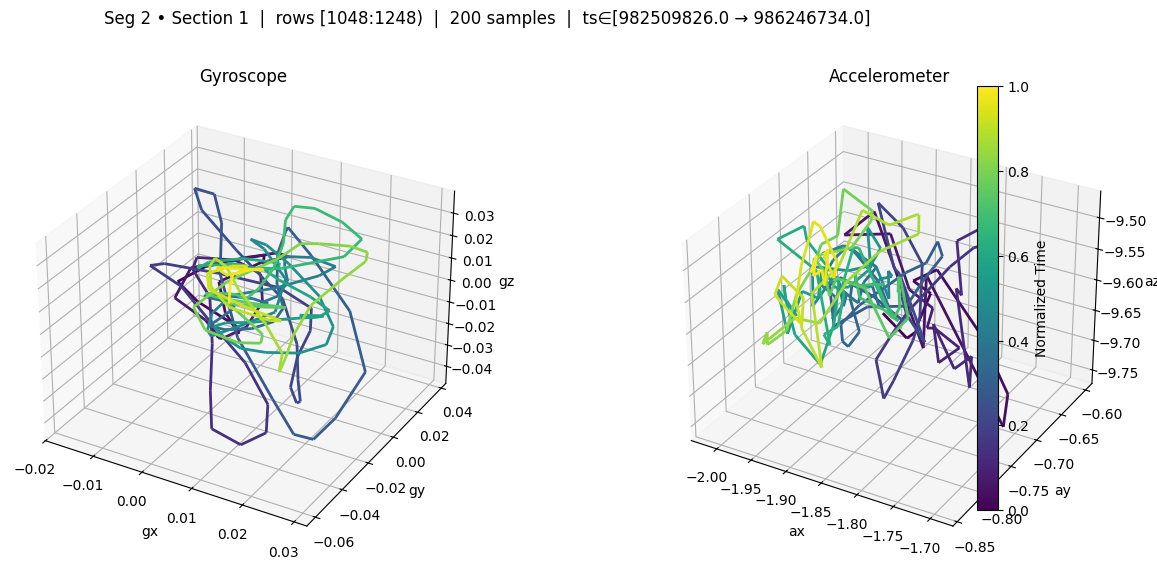

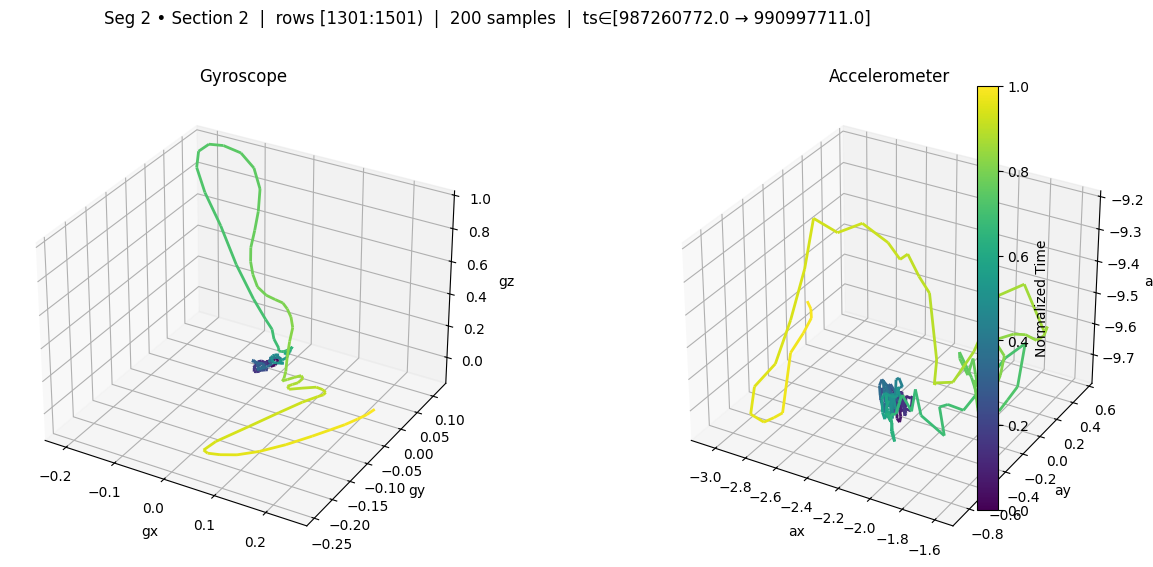

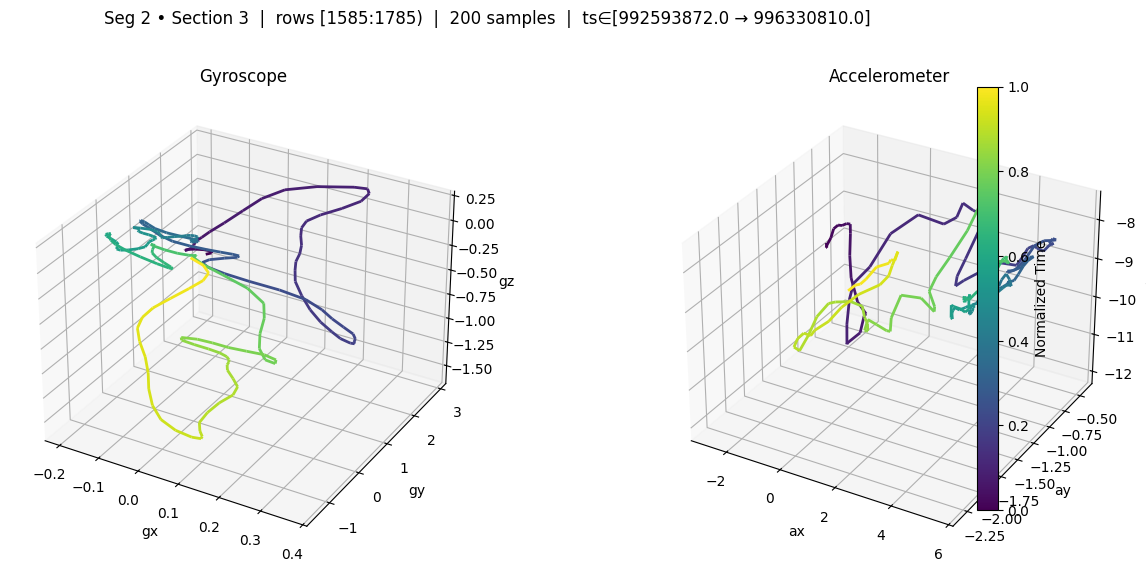

In [5]:
# --- Random 3×200-sample sanity plots using segment_by_tag ---

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"  # <-- set path
WINDOW = 200
N_SECTIONS = 3
SEED = 7
GAP_US = 35_000   # 35 ms tolerance between rows when splitting segments
MERGE_TOL_US = 1000  # acc↔gyro merge tolerance (1 ms)

# 1) Load + split into contiguous segments (your new function)
segs = segment_by_tag(CSV_PATH, gap_threshold_us=GAP_US, min_len=WINDOW*2)  # keep only reasonable-length segments

# 2) Helper: merge one segment's acc/gyro rows into a single IMU table
import pandas as pd
def segment_to_imu(seg_df, merge_tol_us=MERGE_TOL_US):
    seg_df = seg_df.sort_values('timestamp').reset_index(drop=True)

    # carry systemTime if present on acc side
    acc_cols = ['timestamp','x','y','z']
    if 'systemTime' in seg_df.columns:
        acc_cols = ['timestamp','systemTime','x','y','z']

    acc = seg_df[seg_df['tag']=='acc'][acc_cols].rename(
        columns={'x':'acc_x','y':'acc_y','z':'acc_z'}
    )
    gyr = seg_df[seg_df['tag']=='gyro'][['timestamp','x','y','z']].rename(
        columns={'x':'gyro_x','y':'gyro_y','z':'gyro_z'}
    )

    imu = pd.merge_asof(
        acc.sort_values('timestamp'),
        gyr.sort_values('timestamp'),
        on='timestamp',
        direction='nearest',
        tolerance=merge_tol_us
    ).dropna().reset_index(drop=True)

    return imu  # has gyro_x/y/z; systemTime only if it existed on acc rows

# choose a segment (largest by length)
seg_idx = int(np.argmax([len(s) for s in segs]))
imu = segment_to_imu(segs[seg_idx], MERGE_TOL_US)

def take_random_windows_no_overlap(N, window, n, seed=0):
    if N < window * n:
        raise ValueError(f"Recording too short ({N}) for {n}×{window} windows.")
    rng = np.random.default_rng(seed)
    starts, taken = [], np.zeros(N, dtype=bool)
    while len(starts) < n:
        s = int(rng.integers(0, N - window + 1))
        if not taken[s:s+window].any():
            starts.append(s)
            taken[s:s+window] = True
    starts.sort()
    return [(s, s+window) for s in starts]

def _time_norm(ts):
    ts = np.asarray(ts, dtype=float)
    tmin, tmax = float(np.min(ts)), float(np.max(ts))
    d = (tmax - tmin) or 1.0
    return (ts - tmin) / d

def _make_lc(x, y, z, tnorm):
    pts = np.column_stack([x, y, z]).reshape(-1, 1, 3)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    lc = Line3DCollection(segs, cmap=plt.colormaps['viridis'], norm=plt.Normalize(0, 1))
    lc.set_array(np.asarray(tnorm))
    lc.set_linewidth(2.0)
    return lc

def plot_gyro_acc_3d_section(df, s, e, title):
    seg = df.iloc[s:e]
    tnorm = _time_norm(seg['timestamp'])

    fig = plt.figure(figsize=(13, 5.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    lc_g = _make_lc(seg['gyro_x'], seg['gyro_y'], seg['gyro_z'], tnorm)
    ax1.add_collection3d(lc_g)
    ax1.set_title("Gyroscope"); ax1.set_xlabel('gx'); ax1.set_ylabel('gy'); ax1.set_zlabel('gz')
    ax1.auto_scale_xyz(seg['gyro_x'], seg['gyro_y'], seg['gyro_z'])

    lc_a = _make_lc(seg['acc_x'], seg['acc_y'], seg['acc_z'], tnorm)
    ax2.add_collection3d(lc_a)
    ax2.set_title("Accelerometer"); ax2.set_xlabel('ax'); ax2.set_ylabel('ay'); ax2.set_zlabel('az')
    ax2.auto_scale_xyz(seg['acc_x'], seg['acc_y'], seg['acc_z'])

    cbar = fig.colorbar(lc_g, ax=[ax1, ax2], pad=0.05, fraction=0.03)
    cbar.set_label('Normalized Time')
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# 3) Pick random non-overlapping windows from this segment and plot
spans = take_random_windows_no_overlap(len(imu), WINDOW, N_SECTIONS, seed=SEED)
print(f"Segment {seg_idx+1} chosen | imu rows: {len(imu)} | Random sections: {spans}")

for i, (s, e) in enumerate(spans, 1):
    t0, t1 = imu.loc[s, 'timestamp'], imu.loc[e-1, 'timestamp']
    plot_gyro_acc_3d_section(
        imu, s, e,
        title=f"Seg {seg_idx+1} • Section {i}  |  rows [{s}:{e})  |  {WINDOW} samples  |  ts∈[{t0} → {t1}]"
    )


In [6]:
BASE_HYPER = {
    "target_hz": 1000,
    "batch_size": 128,
    "num_workers": 0,
    "epochs": 15,
    "lr": 5e-3,
    "weight_decay": 1e-5,
    "val_split": 0.1,
    "seed": 42,
    "timestamp_unit": "us",
    "hop": 1,
    "loss": "mse",
}

# 10 ms ahead (1 step @ 100 Hz)
HYPER_10ms = {
    **BASE_HYPER,
    "horizons": [1],
    "window": 30,         # small context
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.05,
    "batch_size": 256,    # faster/stable for short horizon
    "lr": 2e-3,
}

# 20 ms ahead (2 steps)
HYPER_20ms = {
    **BASE_HYPER,
    "horizons": [2],
    "window": 60,        # more context
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.10,
    "batch_size": 128,
    "lr": 8e-4,
}

# 30 ms ahead (3 steps)
HYPER_30ms = {
    **BASE_HYPER,
    "epochs":2,
    "horizons": [3],
    "window": 90,        # largest context
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.15,
    "batch_size": 96,     # memory headroom
    "lr": 4e-4,           # gentler for larger net
}

ALL_HYPERS = {
    "10ms": HYPER_10ms,
    "20ms": HYPER_20ms,
    "30ms": HYPER_30ms,
}


In [7]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import math, random
import pandas as pd

# ---- seeds (as before) ----
#torch.manual_seed(HYPER["seed"])
#np.random.seed(HYPER["seed"])
#random.seed(HYPER["seed"])

# ---------- Rate helpers ----------
def _infer_orig_rate_us(ts_col: pd.Series):
    """Estimate rate assuming numeric timestamp in microseconds."""
    ts = pd.to_numeric(ts_col, errors='coerce').to_numpy(dtype=np.float64)
    d = np.diff(ts)
    d = d[d > 0]
    med = np.median(d)
    if not np.isfinite(med) or med <= 0:
        raise ValueError("Cannot infer sampling interval from timestamps.")
    hz = 1e6 / med  # µs -> s
    return hz, med  # (Hz, median delta in µs)

def downsample_to_rate(df: pd.DataFrame, target_hz: int, timestamp_unit: str = "us"):
    """
    Decimate by integer factor using numeric 'timestamp' in microseconds.
    If your source is slower than target_hz, this keeps factor=1 (no upsampling here).
    """
    if timestamp_unit != "us":
        raise NotImplementedError("downsample_to_rate expects numeric 'timestamp' in µs.")
    orig_hz, med_us = _infer_orig_rate_us(df["timestamp"])
    factor = max(1, int(round(orig_hz / target_hz)))
    ds = df.iloc[::factor].reset_index(drop=True)
    actual_hz, _ = _infer_orig_rate_us(ds["timestamp"]) if len(ds) > 3 else (orig_hz/factor, med_us*factor)
    return ds, {"orig_hz": orig_hz, "factor": factor, "actual_hz": actual_hz}

def resample_to_rate_timestamp(df, target_hz: int, ts_col: str = "timestamp"):
    """
    Resample to exact target_hz on a regular grid using numeric 'timestamp' in µs.
    Linear interpolation of numeric columns.
    """
    df2 = df.sort_values(ts_col).reset_index(drop=True).copy()
    ts = pd.to_numeric(df2[ts_col], errors='coerce').to_numpy(dtype=np.float64)
    mask = np.isfinite(ts)
    df2 = df2.loc[mask].reset_index(drop=True)
    ts = ts[mask]
    if len(ts) < 2:
        raise ValueError("Not enough valid timestamps to resample.")

    step_us = 1e6 / float(target_hz)
    new_ts = np.arange(ts[0], ts[-1] + 0.5*step_us, step_us, dtype=np.float64)

    # interpolate only numeric columns
    num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
    if ts_col not in num_cols:
        num_cols.append(ts_col)
    out = {ts_col: new_ts}
    for col in num_cols:
        if col == ts_col:  # already set
            continue
        y = df2[col].to_numpy(dtype=np.float64)
        out[col] = np.interp(new_ts, ts, y)

    return pd.DataFrame(out)


# ---------- Windowing ----------
def make_supervised_windows(arr_xyz: np.ndarray, window: int, horizon: int, hop: int = 1):
    # arr_xyz must be (N, 3)
    if arr_xyz.ndim != 2:
        raise ValueError(f"arr_xyz must be 2D (N,3), got {arr_xyz.shape}")
    if arr_xyz.shape[1] != 3:                 # fix accidental transpose
        if arr_xyz.shape[0] == 3:
            arr_xyz = arr_xyz.T
        else:
            raise ValueError(f"Expected 3 features, got {arr_xyz.shape[1]}")

    N = len(arr_xyz)
    M = N - window - horizon + 1
    if M <= 0:
        raise ValueError("Not enough samples for the requested window+horizon.")

    # slide ONLY on time axis (axis=0) -> (N-window+1, window, 3)
    X_full = np.lib.stride_tricks.sliding_window_view(arr_xyz, window, axis=0)  # (N-T+1, T, 3) on NumPy>=1.20
    # Guard against (N-T+1, 3, T) variants
    if X_full.ndim == 3 and X_full.shape[-1] != 3 and X_full.shape[-2] == 3:
      X_full = np.swapaxes(X_full, -1, -2)
    X_full = X_full[:M]
    y_full = arr_xyz[(window - 1 + horizon):(window - 1 + horizon + M)]

    X = X_full[::hop].astype(np.float32)
    y = y_full[::hop].astype(np.float32)
    return X, y

# ---------- Dataset ----------
class GyroWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (M, T, 3)
        self.y = torch.from_numpy(y)  # (M, 3)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

# ---------- Model ----------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 3)
    def forward(self, x):
        out, _ = self.lstm(x)     # (B, T, H)
        return self.fc(out[:, -1, :])


In [8]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 3)  # predict gx, gy, gz
    def forward(self, x):
        # x: (B, T, 3)
        out, _ = self.lstm(x)       # (B, T, H)
        last = out[:, -1, :]        # (B, H)
        return self.fc(last)         # (B, 3)

In [9]:
import time, math, torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

import torch
from torch import nn

def _make_loss(name):
    name = name.lower()
    if name == "mse":   return nn.MSELoss()
    if name == "mae":   return nn.L1Loss()
    if name == "huber": return nn.SmoothL1Loss(beta=1.0)
    raise ValueError(f"Unknown loss {name}")

def train_one_model_raw(X_train, y_train, X_val, y_val, hyper):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_ds   = TensorDataset(torch.from_numpy(X_val).float(),   torch.from_numpy(y_val).float())
    train_loader = DataLoader(train_ds, batch_size=hyper["batch_size"], shuffle=True,  num_workers=hyper["num_workers"])
    val_loader   = DataLoader(val_ds,   batch_size=hyper["batch_size"], shuffle=False, num_workers=hyper["num_workers"])

    model = LSTMRegressor(input_size=3,
                          hidden_size=hyper["hidden_size"],
                          num_layers=hyper["num_layers"],
                          dropout=hyper["dropout"]).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=hyper["lr"], weight_decay=hyper["weight_decay"])
    loss_fn = _make_loss(hyper["loss"])
    best_val = float("inf"); best_state=None

    for epoch in range(1, hyper["epochs"]+1):
        model.train(); tr_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)        # raw deg/s loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_sum += loss.item() * len(xb)
        train_loss = tr_sum / len(train_ds)

        # val
        model.eval(); va_sum = 0.0; errs=[]
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                p = model(xb)
                va_sum += loss_fn(p, yb).item() * len(xb)
                errs.append((p - yb).detach().cpu().numpy())
        val_loss = va_sum / len(val_ds)
        e = np.concatenate(errs, axis=0)
        val_mae  = float(np.mean(np.abs(e)))
        val_rmse = float(np.sqrt(np.mean(e**2)))

        print(f"epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} "
              f"| val MAE {val_mae:.4f} | RMSE {val_rmse:.4f} deg/s")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    if best_state: model.load_state_dict(best_state)
    return model, best_val


In [10]:
# ---- Data prep (segment -> merge -> rate -> split -> normalize) ----
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"  # <--- change



def prepare_data_no_norm(HYPER, csv_path, gap_us=35_000, merge_tol_us=None):
    TARGET_HZ = HYPER["target_hz"]
    if merge_tol_us is None:
        merge_tol_us = globals().get("MERGE_TOL_US", 2000)

    # 1) segment
    segments = segment_by_tag(csv_path, gap_threshold_us=gap_us, min_len=1)
    if not segments:
        raise ValueError("No segments found.")
    seg_idx = int(np.argmax([len(s) for s in segments]))
    seg = segments[seg_idx].reset_index(drop=True)
    print(f"Segment {seg_idx+1}: {len(seg)} samples, ts {seg['timestamp'].iloc[0]} → {seg['timestamp'].iloc[-1]}")

    # 2) merge acc↔gyro
    imu = segment_to_imu(seg, merge_tol_us)
    print(f"Merged IMU: {len(imu)} rows | cols: {list(imu.columns)}")

    # 3) rate → TARGET_HZ
    orig_hz, _ = _infer_orig_rate_us(imu["timestamp"])
    if orig_hz >= TARGET_HZ:
        df_ds, info = downsample_to_rate(imu, TARGET_HZ, timestamp_unit="us")
        print(f"Rate: ~{info['orig_hz']:.1f}Hz → factor {info['factor']} → ~{info['actual_hz']:.1f}Hz")
    else:
        df_ds = resample_to_rate_timestamp(imu, TARGET_HZ, ts_col="timestamp")
        print(f"Rate: upsample → {TARGET_HZ}Hz; rows={len(df_ds)}")
    print(f"After rate: {len(df_ds)} samples")

    # 4) raw gyro (deg/s)
    gyro = df_ds[["gyro_x","gyro_y","gyro_z"]].to_numpy(dtype=np.float32)

    # 5) contiguous split
    val_len = max(1, int(len(gyro) * HYPER["val_split"]))
    train_arr = gyro[:-val_len]
    val_arr   = gyro[-val_len:]
    print(f"Split: train={len(train_arr)} | val={len(val_arr)}")

    # 6) horizon info
    h = HYPER["horizons"][0]
    ms = 1000.0 * h / TARGET_HZ
    print(f"Horizon: {h} steps @ {TARGET_HZ}Hz ≈ {ms:.1f} ms")

    split_end = len(train_arr)  # for window mapping
    return gyro, train_arr, val_arr, split_end, TARGET_HZ


In [11]:
MODELS = {}
VAL_SCORES = {}
VAL_BUFFERS = {}

for name, HYPER in ALL_HYPERS.items():
    print(f"\n==============================")
    print(f"Training config: {name} | window={HYPER['window']} | horizon={HYPER['horizons'][0]} step(s)")
    print(f"==============================")

    gyro_raw, train_raw, val_raw, split_end, TARGET_HZ = prepare_data_no_norm(
        HYPER, csv_path=CSV_PATH, gap_us=35_000, merge_tol_us=globals().get("MERGE_TOL_US", 2000)
    )

    hop = HYPER.get("hop", 1)
    T   = HYPER["window"]
    h   = HYPER["horizons"][0]

    # windows from RAW (deg/s)
    X_all, y_all = make_supervised_windows(gyro_raw, T, h, hop=hop)
    if X_all.ndim == 3 and X_all.shape[-1] != 3 and X_all.shape[-2] == 3:
        X_all = np.swapaxes(X_all, -1, -2)  # ensure (N, T, 3)
    total_windows = len(X_all)

    # map contiguous time split to window index
    max_start_in_train = split_end - (T - 1) - h
    split_idx = max(0, min(total_windows, (max_start_in_train + 1 + (hop - 1)) // hop))
    if split_idx <= 0 or split_idx >= total_windows:
        fallback = max(1, int(0.8 * total_windows))
        print(f"  [note] adjusted split: computed={split_idx}, total={total_windows} -> using {fallback}/{total_windows-fallback}")
        split_idx = fallback

    X_tr, y_tr = X_all[:split_idx], y_all[:split_idx]
    X_va, y_va = X_all[split_idx:], y_all[split_idx:]
    print(f"  windows: total={total_windows} | train={len(X_tr)} | val={len(X_va)} | hop={hop}")

    # train on raw units
    model, val_metric = train_one_model_raw(X_tr, y_tr, X_va, y_va, HYPER)
    MODELS[name] = model
    VAL_SCORES[name] = val_metric

    # buffers for plotting/eval (no mean/std needed)
    VAL_BUFFERS[name] = {
        "X_va": X_va, "y_va": y_va,
        "h": h, "T": T, "target_hz": TARGET_HZ,
    }

    # save
    ckpt_path = f"model_{name}_w{T}_h{h}.pt"
    torch.save({"state_dict": model.state_dict(), "hyper": HYPER, "target_hz": TARGET_HZ}, ckpt_path)
    print(f"  saved -> {ckpt_path}")

print("\nValidation (deg/s^2) per model:")
for key in ["10ms","20ms","30ms"]:
    if key in VAL_SCORES:
        print(f"{key:>4}: {VAL_SCORES[key]:.5f}")


Training config: 10ms | window=30 | horizon=1 step(s)
Found 19942 samples total
Segment 1: 3148 samples  [0 → 3147]  ts_range=[933254608.0, 962792541.0]
Segment 2: 3754 samples  [3148 → 6901]  ts_range=[962830108.0, 998058441.0]
Segment 3: 1086 samples  [6902 → 7987]  ts_range=[998095977.0, 1008273986.0]
Segment 4: 538 samples  [7988 → 8525]  ts_range=[1008311553.0, 1013344238.0]
Segment 5: 22 samples  [8526 → 8547]  ts_range=[1013381774.0, 1013569580.0]
Segment 6: 3214 samples  [8548 → 11761]  ts_range=[1013607116.0, 1043765716.0]
Segment 7: 1650 samples  [11762 → 13411]  ts_range=[1043803253.0, 1059276855.0]
Segment 8: 1528 samples  [13412 → 14939]  ts_range=[1059314392.0, 1073642456.0]
Segment 9: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 10: 328 samples  [16236 → 16563]  ts_range=[2468627258.0, 2471688324.0]
Segment 11: 942 samples  [16564 → 17505]  ts_range=[2471725891.0, 2480552246.0]
Segment 12: 1142 samples  [17506 → 18647]  ts_range=[24805898

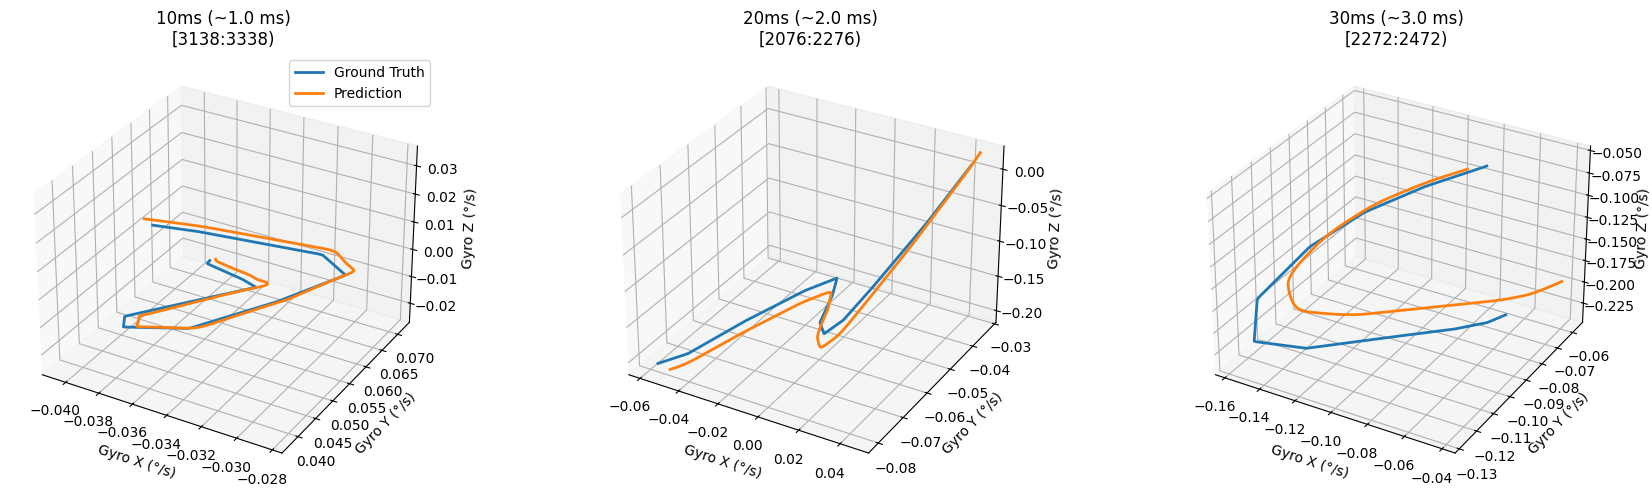

In [12]:
# Side-by-side 3D plots for all three models (raw deg/s)
import numpy as np, matplotlib.pyplot as plt, torch

MODEL_KEYS = ["10ms","20ms","30ms"]
N = 200
rng = np.random.default_rng(7)

fig = plt.figure(figsize=(18,5))

for i, key in enumerate(MODEL_KEYS, start=1):
    model = MODELS[key]
    buf = VAL_BUFFERS[key]
    X_va, y_va = buf["X_va"], buf["y_va"]
    h, target_hz = buf["h"], buf["target_hz"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        preds = model(torch.from_numpy(X_va).float().to(device)).cpu().numpy()

    Nv = len(preds)
    start = int(rng.integers(0, max(1, Nv - N + 1)))
    end   = min(start + N, Nv)
    pred_seg  = preds[start:end]
    truth_seg = y_va[start:end]

    ax = fig.add_subplot(1,3,i, projection='3d')
    ax.plot(truth_seg[:,0], truth_seg[:,1], truth_seg[:,2], label="Ground Truth", linewidth=2)
    ax.plot(pred_seg[:,0],  pred_seg[:,1],  pred_seg[:,2],  label="Prediction",  linewidth=2)
    ax.set_xlabel("Gyro X (°/s)"); ax.set_ylabel("Gyro Y (°/s)"); ax.set_zlabel("Gyro Z (°/s)")
    ms = 1000.0 * h / target_hz
    ax.set_title(f"{key} (~{ms:.1f} ms)\n[{start}:{end})")
    if i == 1: ax.legend()

plt.tight_layout(); plt.show()